In [1]:
# uncomment the following line to install required packages. I may have missed some.
#import Pkg; Pkg.add(["Flux", "Zygote", "CSV", "DataFrames", "Statistics", "ProgressMeter", "Plots"])

In [2]:
using Flux
using Zygote
using CSV
using DataFrames
using Statistics
using ProgressMeter
using Plots

In [3]:
nx = 2 # number of states
lr = 2e-3 # learning rate
iterations = 500;

## Data preparation

In [4]:
df = CSV.read("cascaded_tanks.csv", DataFrame)
first(df, 5)

Row,uEst,uVal,yEst,yVal,Ts,Column6
,Float64,Float64,Float64,Float64,Int64?,Missing
1,3.2567,0.97619,5.205,4.9728,4,missing
2,3.2466,0.99921,5.2154,4.9722,missing,missing
3,3.2309,1.0172,5.2215,4.9703,missing,missing
4,3.2097,1.0318,5.2142,4.988,missing,missing
5,3.1836,1.0456,5.2001,4.9825,missing,missing


In [5]:
nu = 1 # number of inputs
ny = 1 # number of outputs
seq_len = length(df.yEst)

y_train = reshape(df.yEst, ny, seq_len) # reshape to 1 row and seq_len columns
u_train = reshape(df.uEst, nu, seq_len) 

y_test = reshape(df.yVal, ny, seq_len) # reshape to 1 row and seq_len columns
u_test = reshape(df.uVal, nu, seq_len) 

size(y_train), size(u_train)

((1, 1024), (1, 1024))

In [6]:
# Compute the mean and standard deviation for normalization
u_mean = mean(u_train)
u_std = std(u_train)
y_mean = mean(y_train)
y_std = std(y_train)

2.1661934355291974

In [7]:
# Normalize the training data
y = (y_train .- y_mean) ./ y_std;
u = (u_train .- u_mean) ./ u_std;

## Training

In [8]:
params = (
    A = randn(nx, nx)./10.0,
    B = randn(nx, nu)./10.0,
    C = randn(ny, nx)./10.0,
    x0 = randn(nx)
);

In [9]:
function lti_cell(p, xt, ut)
    x_new = p.A * xt + p.B * ut
    yt = p.C * xt
    return yt, x_new
end

lti_cell (generic function with 1 method)

In [10]:
function simulate(p, u; grads=false)
    xt = p.x0
    if grads
        y_hat = Zygote.Buffer(zeros(size(p.C, 1), size(u, 2)))  # mutable buffer
    else
        y_hat = zeros(size(p.C, 1), size(u, 2))  # normal array
    end

    for (t, ut) in enumerate(eachcol(u))
        yt, xt = lti_cell(p, xt, ut)
        y_hat[:, t] = yt
    end

    if grads
        return copy(y_hat)  # return the mutable buffer directly
    else
        return y_hat  # return the normal array
    end
end

simulate (generic function with 1 method)

In [11]:
function forward_loss(p, u, y)
    y_hat = simulate(p, u; grads=true)
    loss = sum((y .- y_hat).^2) / size(y_hat, 2)
    return loss
end

forward_loss (generic function with 1 method)

In [12]:
opt_state = Flux.setup(Flux.Adam(lr), params)  # initialize Adam's internal state for your params

(A = Leaf(Adam(eta=0.002, beta=(0.9, 0.999), epsilon=1.0e-8), ([0.0 0.0; 0.0 0.0], [0.0 0.0; 0.0 0.0], (0.9, 0.999))), B = Leaf(Adam(eta=0.002, beta=(0.9, 0.999), epsilon=1.0e-8), ([0.0; 0.0;;], [0.0; 0.0;;], (0.9, 0.999))), C = Leaf(Adam(eta=0.002, beta=(0.9, 0.999), epsilon=1.0e-8), ([0.0 0.0], [0.0 0.0], (0.9, 0.999))), x0 = Leaf(Adam(eta=0.002, beta=(0.9, 0.999), epsilon=1.0e-8), ([0.0, 0.0], [0.0, 0.0], (0.9, 0.999))))

In [13]:
losses = []
@showprogress for itr in 1:iterations
    loss, grads = Zygote.withgradient(params) do p
        forward_loss(p, u, y)
    end
    
    Flux.Optimise.update!(opt_state, params, grads[1])
    
    #if itr % 10 == 0
    #    println("Epoch $itr, loss = $loss")
    #end
    push!(losses, loss)
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


## Evaluation

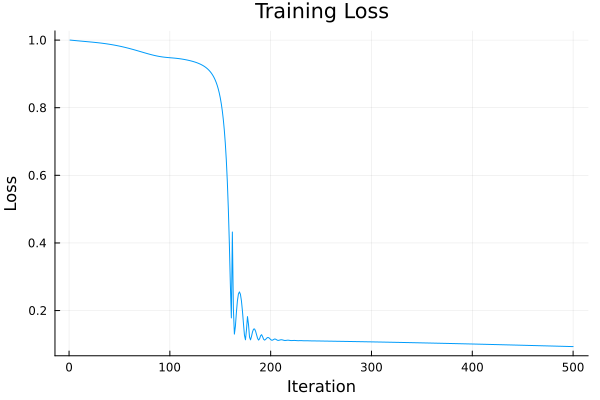

In [14]:
plot(losses, xlabel="Iteration", ylabel="Loss", title="Training Loss", legend=false)

In [15]:
function r_squared(y, y_hat)
    ss_res = sum((y .- y_hat).^2)
    ss_tot = sum((y .- mean(y)).^2)
    return 1 - ss_res / ss_tot
end

r_squared (generic function with 1 method)

In [16]:
y_train_hat = simulate(params, u)
y_train_hat = y_train_hat .* y_std .+  y_mean # denormalize the output 

1×1024 Matrix{Float64}:
 5.39375  4.88074  4.86451  4.90501  …  4.09431  4.14789  4.20257  4.25795

In [17]:
mse = mean((y_train .- y_train_hat).^2, dims=2)
rmse = sqrt.(mse)

r_squared(y_train, y_train_hat)

0.9066139194254722

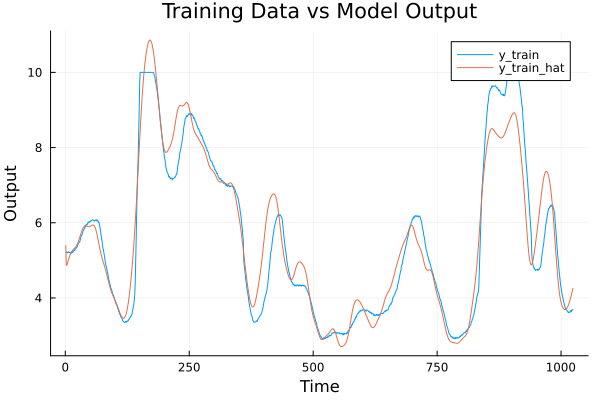

In [18]:
plot(1:size(y_train, 2), y_train[1, :], label="y_train", xlabel="Time", ylabel="Output", title="Training Data vs Model Output")
plot!(1:size(y_train_hat, 2), y_train_hat[1, :], label="y_train_hat")

In [19]:
u_test_norm = (u_test .- u_mean) ./ u_std
y_test_hat = simulate(params, u_test_norm)
y_test_hat = y_test_hat .* y_std .+ y_mean  # denormalize the output 

1×1024 Matrix{Float64}:
 5.39375  5.17515  5.02791  4.893  …  3.11718  2.99968  2.88419  2.7721

In [20]:
r_squared(y_test, y_test_hat)

0.8723038331747033

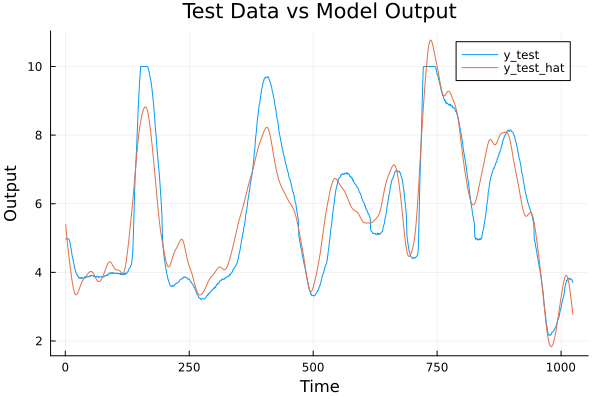

In [21]:
plot(1:size(y_test, 2), y_test[1, :], label="y_test", xlabel="Time", ylabel="Output", title="Test Data vs Model Output")
plot!(1:size(y_test_hat, 2), y_test_hat[1, :], label="y_test_hat")